In [7]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import ADASYN
from imblearn.ensemble import BalancedRandomForestClassifier
import joblib
import time
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [8]:

df = pd.read_csv('https://raw.githubusercontent.com/shadiajaafar1/ParcialML2/main/dataset_final%20(1).csv')
X = df.drop('isFraud', axis=1)
y = df['isFraud']

imputer = KNNImputer(n_neighbors=5)
X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

In [9]:
pipelines = {
    'logistic_regression': Pipeline([
        ('scaler', StandardScaler()),
        ('logistic_regression', LogisticRegression(max_iter=10000, solver='liblinear', penalty='l2', n_jobs=-1))
    ]),
    'random_forest': Pipeline([
        ('scaler', StandardScaler()),
        ('random_forest', RandomForestClassifier(random_state=2, n_jobs=-1))
    ]),
    'decision_tree': Pipeline([
        ('scaler', StandardScaler()),
        ('decision_tree', DecisionTreeClassifier(random_state=0))
    ]),
    'xgboost': Pipeline([
        ('scaler', StandardScaler()),
        ('xgboost', XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1))
    ]),
    'naive_bayes': Pipeline([
        ('scaler', StandardScaler()),
        ('naive_bayes', GaussianNB())
    ]),
    'knn': Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_jobs=-1))
    ]),
    'balanced_random_forest': Pipeline([
        ('scaler', StandardScaler()),
        ('balanced_random_forest', BalancedRandomForestClassifier(random_state=42, n_jobs=-1))
    ])
}

param_grid = {
    'logistic_regression': {
        'logistic_regression__C': [0.1, 1, 10, 100],
        'logistic_regression__penalty': ['l1', 'l2']
    },
    'random_forest': {
        'random_forest__n_estimators': [5, 10, 50],
        'random_forest__max_depth': [10, 20, 30]
    },
    'decision_tree': {
        'decision_tree__max_depth': [3, 4, 6, 7]
    },
    'xgboost': {
        'xgboost__n_estimators': [50, 100, 200],
        'xgboost__max_depth': [3, 5, 7]
    },
    'naive_bayes': {
        'naive_bayes__var_smoothing': [1e-9, 1e-8, 1e-6]
    },
    'knn': {
        'knn__n_neighbors': [3, 5, 7]
    },
    'balanced_random_forest': {
        'balanced_random_forest__n_estimators': [50, 100, 200],
        'balanced_random_forest__max_depth': [10, 20, 30]
    }
}

Training models:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 8 candidates, totalling 40 fits


Training models:  14%|█▍        | 1/7 [04:43<28:18, 283.04s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Training models:  29%|██▊       | 2/7 [10:19<26:11, 314.39s/it]

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Training models:  43%|████▎     | 3/7 [10:55<12:29, 187.48s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Training models:  57%|█████▋    | 4/7 [12:55<08:02, 160.71s/it]

Fitting 5 folds for each of 3 candidates, totalling 15 fits


Training models:  71%|███████▏  | 5/7 [13:01<03:29, 104.87s/it]

Fitting 5 folds for each of 3 candidates, totalling 15 fits


Training models:  86%|████████▌ | 6/7 [48:58<13:22, 802.56s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Training models: 100%|██████████| 7/7 [58:46<00:00, 503.84s/it]


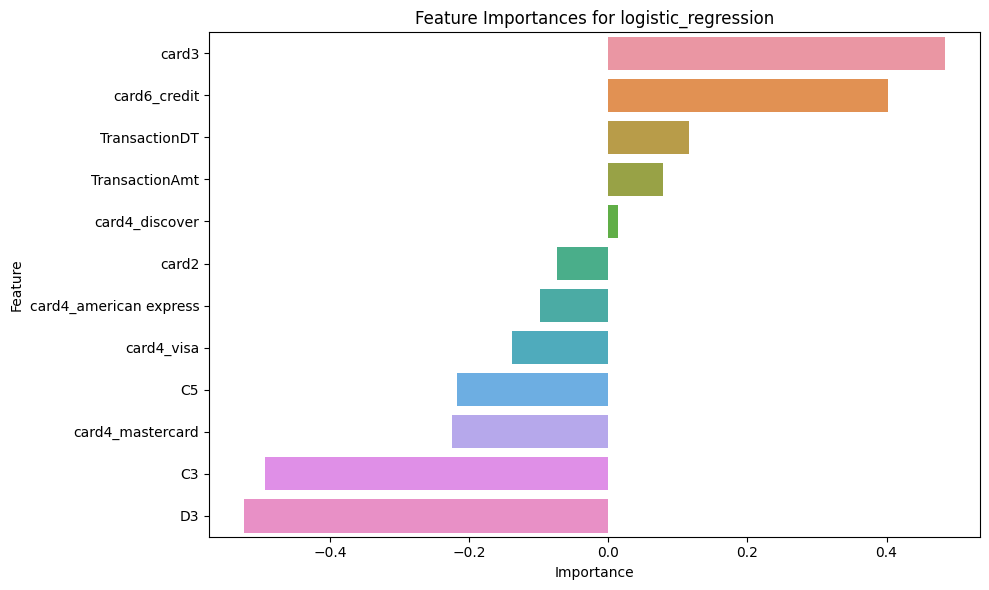

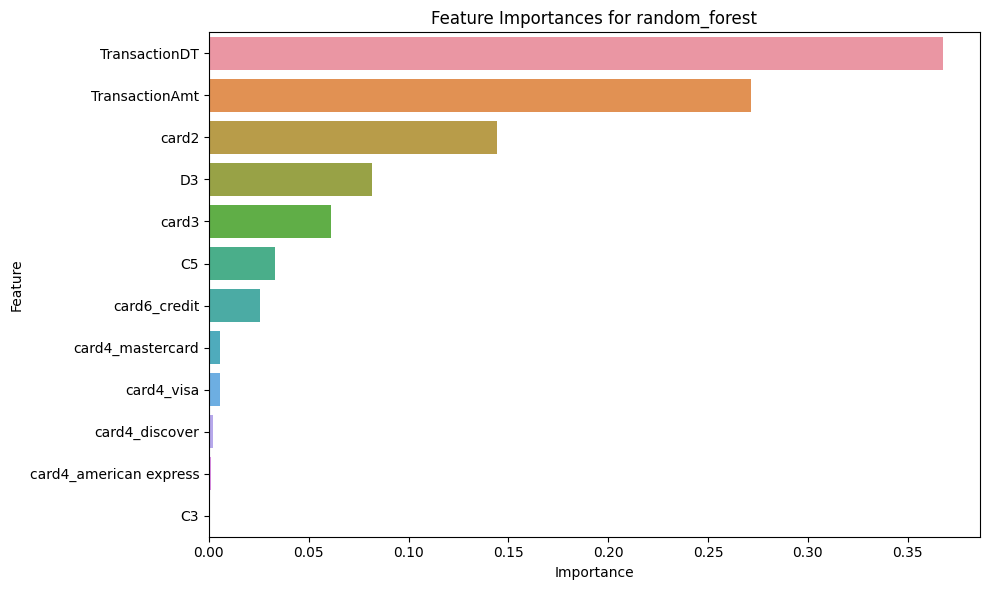

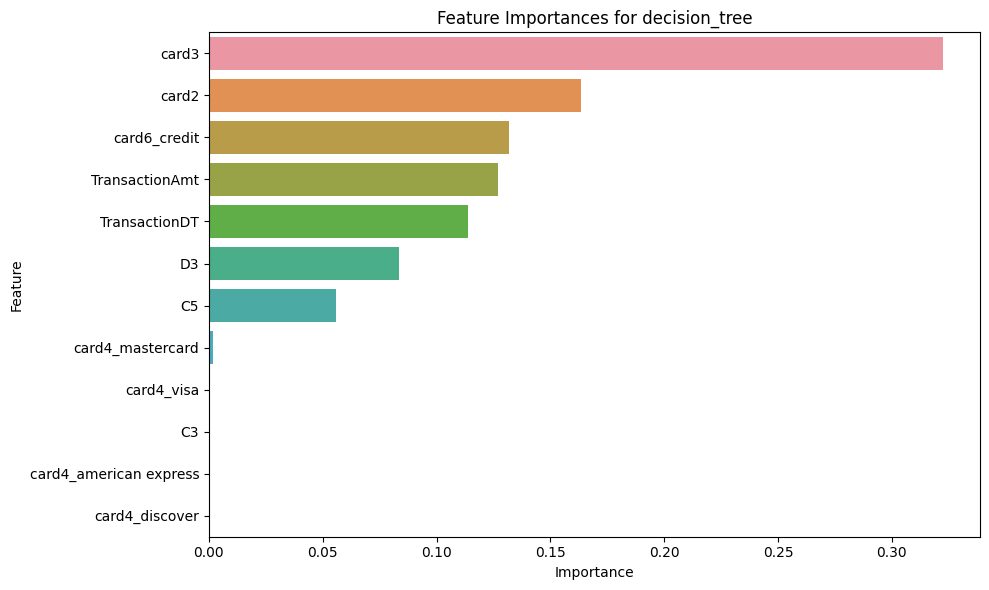

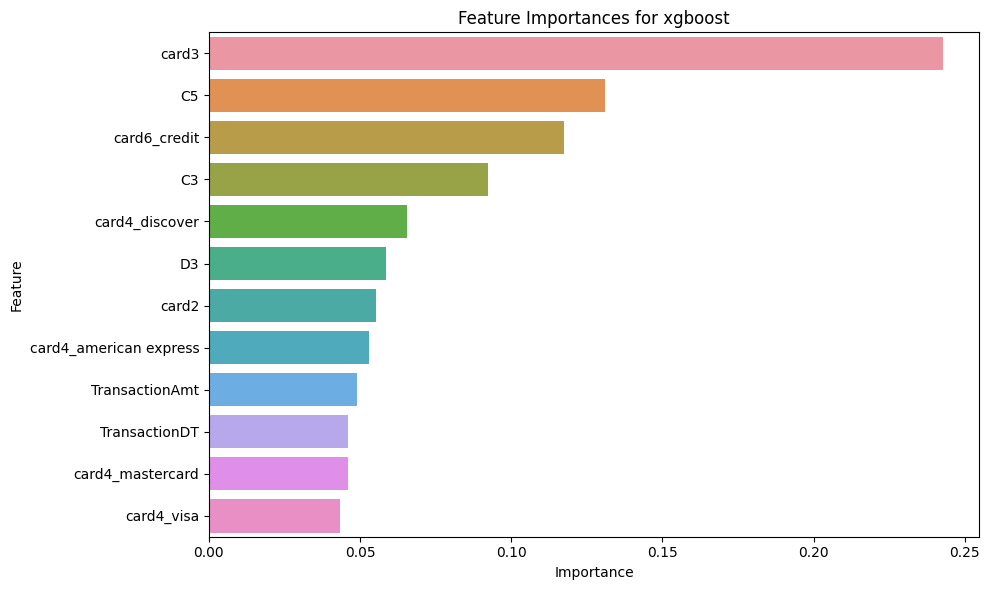

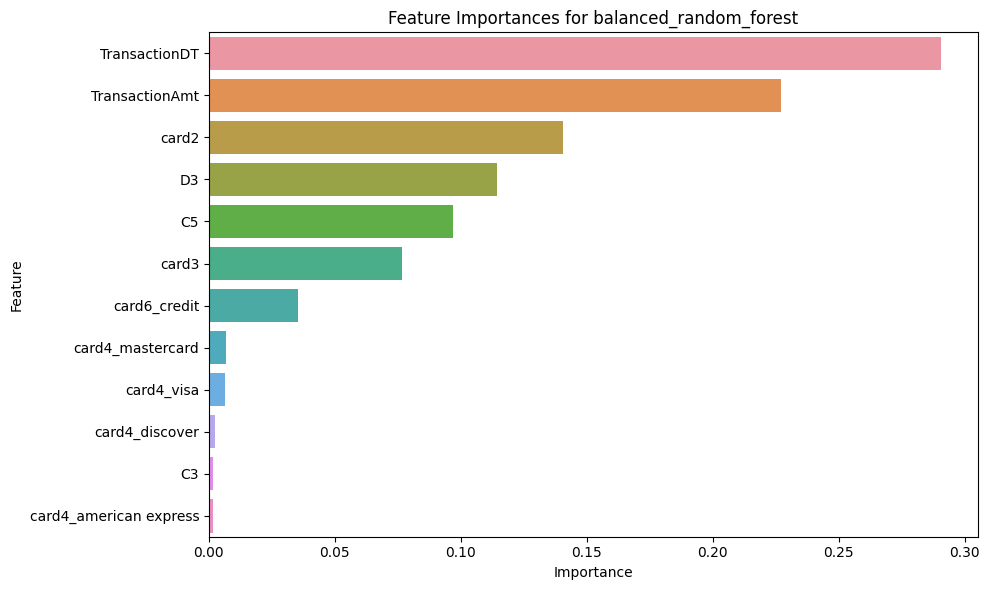

In [17]:
results = []
trained_models = {}
feature_importances = {}

# Entrenar y evaluar los modelos
for model_name, pipeline in tqdm(pipelines.items(), desc="Training models"):
    start_time = time.time()
    grid_search = GridSearchCV(pipeline, param_grid[model_name], cv=StratifiedKFold(n_splits=5), scoring='roc_auc', verbose=1)
    grid_search.fit(X_train, y_train)
    end_time = time.time()

    # Almacenar el mejor modelo encontrado por GridSearchCV
    best_model = grid_search.best_estimator_
    trained_models[model_name] = best_model

    # Predicciones y cálculo de métricas
    y_pred = best_model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Almacenar los resultados y los mejores parámetros
    results.append({
        'Model': model_name, 
        'ROC AUC': roc_auc, 
        'Precision': precision, 
        'Recall': recall, 
        'F1 Score': f1, 
        'Elapsed Time': end_time - start_time,
        'Best Params': grid_search.best_params_
    })
    
    # Obtener la importancia de variables según el tipo de modelo
    if hasattr(best_model, 'named_steps'):  # Para pipelines
        model = best_model.named_steps[model_name]
    else:
        model = best_model
    
    if hasattr(model, 'feature_importances_'):
        feature_importances[model_name] = model.feature_importances_
    elif hasattr(model, 'coef_'):
        feature_importances[model_name] = model.coef_[0]

# Crear DataFrame de resultados
results_df = pd.DataFrame(results)
results_df.to_pickle('results.pkl')
joblib.dump(trained_models, 'trained_models.pkl')

# Guardar la importancia de variables en un DataFrame
feature_importances_df = pd.DataFrame(feature_importances, index=df.columns.drop('isFraud'))
feature_importances_df.to_pickle('feature_importances.pkl')

# Visualización de la importancia de variables
for model_name, importances in feature_importances.items():
    importance_df = pd.DataFrame({
        'Feature': df.columns.drop('isFraud'),
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'Feature Importances for {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

In [22]:
results_df

,Model,ROC AUC,Precision,Recall,F1 Score,Elapsed Time,Best Params
0,logistic_regression,0.740867,0.071429,0.000471,0.000937,282.801426,"{'logistic_regression__C': 100, 'logistic_regr..."
1,random_forest,0.882752,0.902703,0.157473,0.268165,335.226204,"{'random_forest__max_depth': 20, 'random_fores..."
2,decision_tree,0.805691,0.656863,0.031589,0.060279,36.284023,{'decision_tree__max_depth': 7}
3,xgboost,0.879682,0.840153,0.154880,0.261545,118.957039,"{'xgboost__max_depth': 7, 'xgboost__n_estimato..."
4,naive_bayes,0.733516,0.078945,0.615276,0.139935,5.616665,{'naive_bayes__var_smoothing': 1e-06}
5,knn,0.770721,0.556835,0.182461,0.274858,1773.446197,{'knn__n_neighbors': 7}
6,balanced_random_forest,0.882432,0.124836,0.809288,0.216306,584.580105,"{'balanced_random_forest__max_depth': 30, 'bal..."


# Modelos Eficaces: 

Random Forest y XGBoost son los más eficaces en términos de equilibrio entre precisión y recall, con un buen número de verdaderos positivos y falsos negativos manejables. Son recomendables para la detección de fraudes en este conjunto de datos.

# Modelos con Problemas de Falsos Positivos:

Naive Bayes y Balanced Random Forest tienen un alto número de falsos positivos, lo que puede ser problemático si las alertas falsas son costosas.

# Modelos Menos Eficaces:

Logistic Regression y Decision Tree tienen un rendimiento inferior, con muy pocos verdaderos positivos y un alto número de falsos negativos, lo que los hace inadecuados para la detección de fraudes.


## Random Forest y XGBoost son las mejores opciones para la detección de fraudes en este caso, proporcionando un buen equilibrio entre precisión y recall.


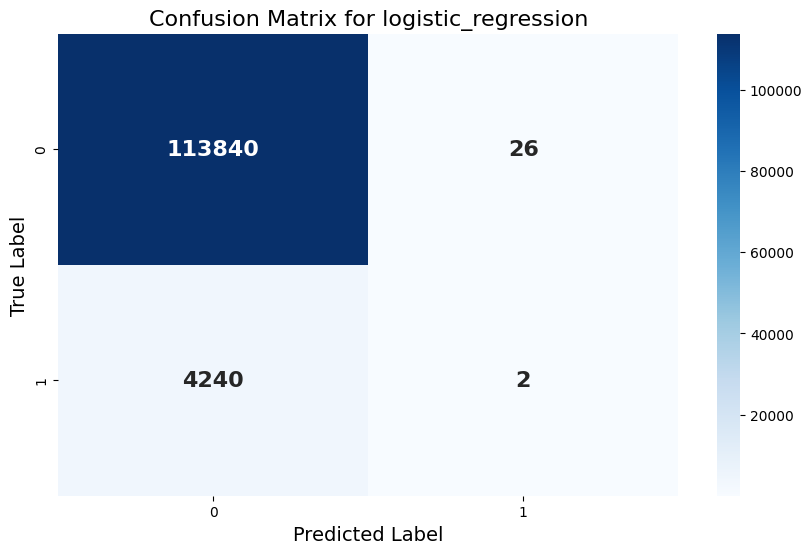

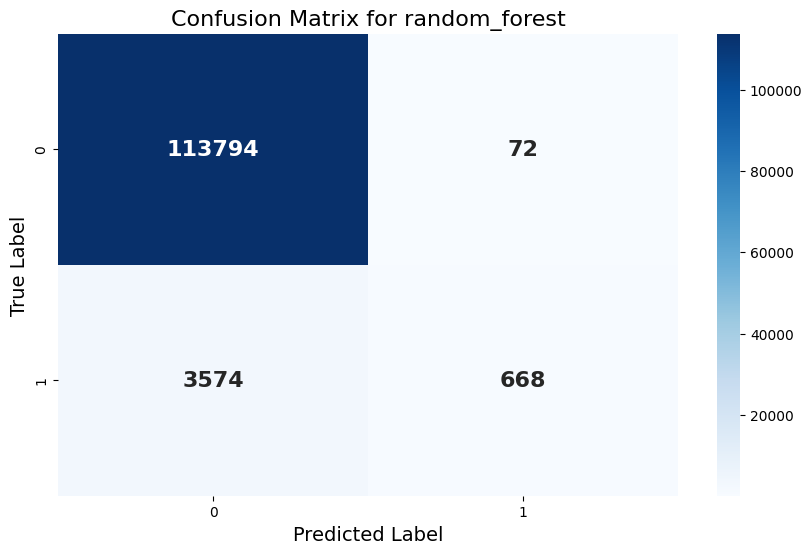

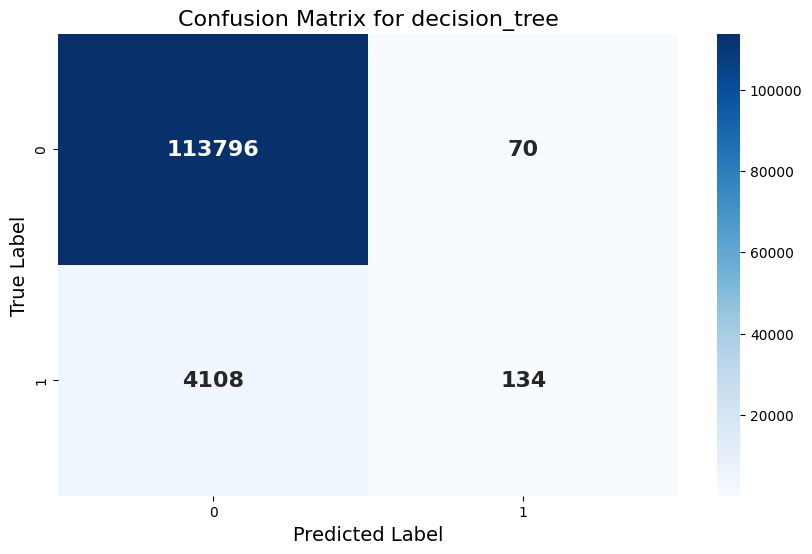

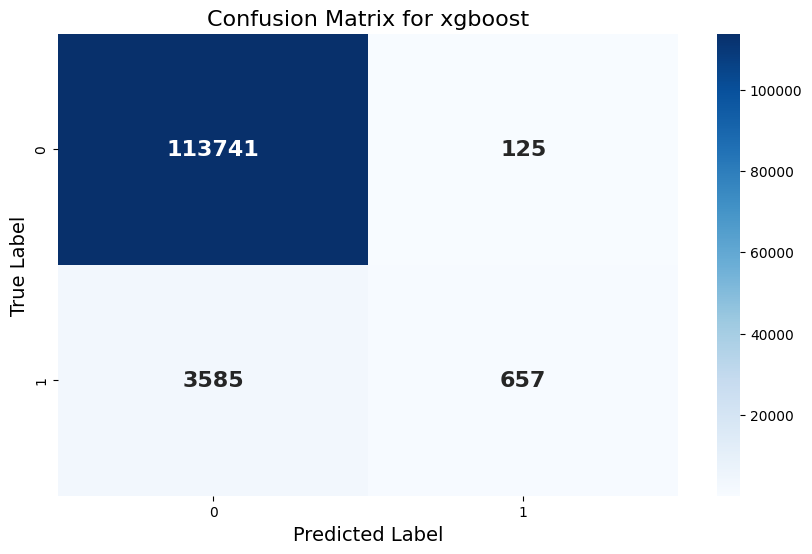

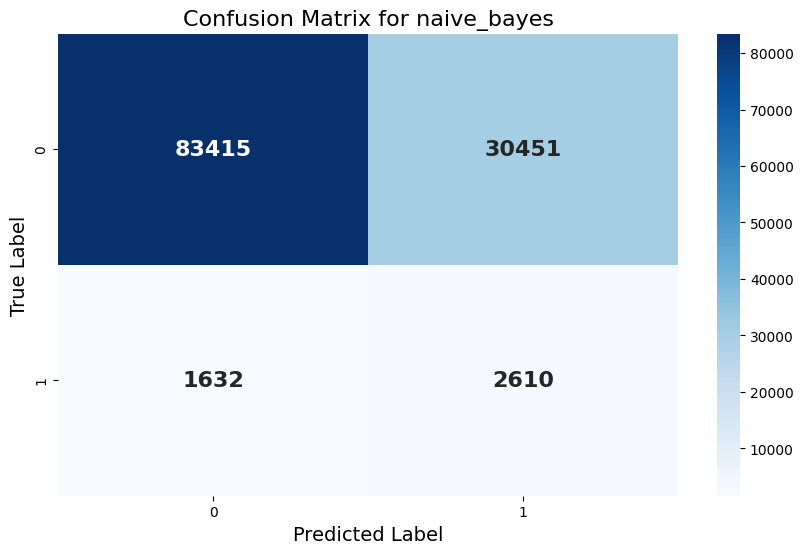

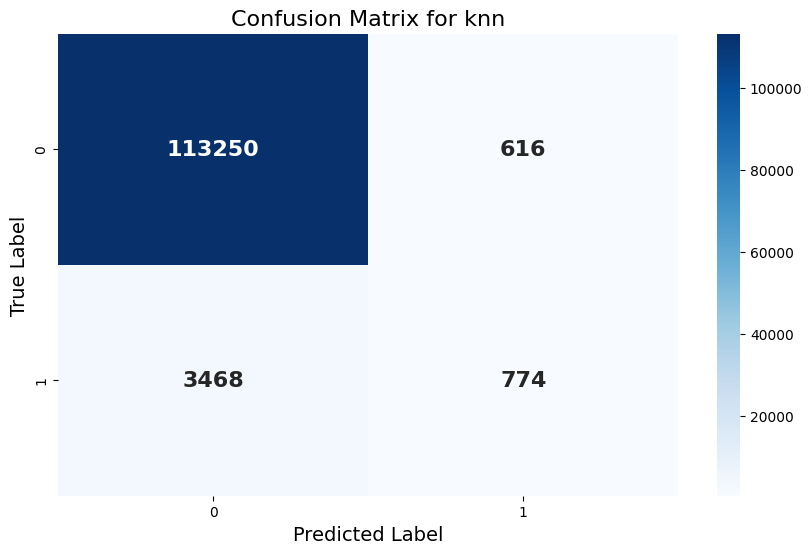

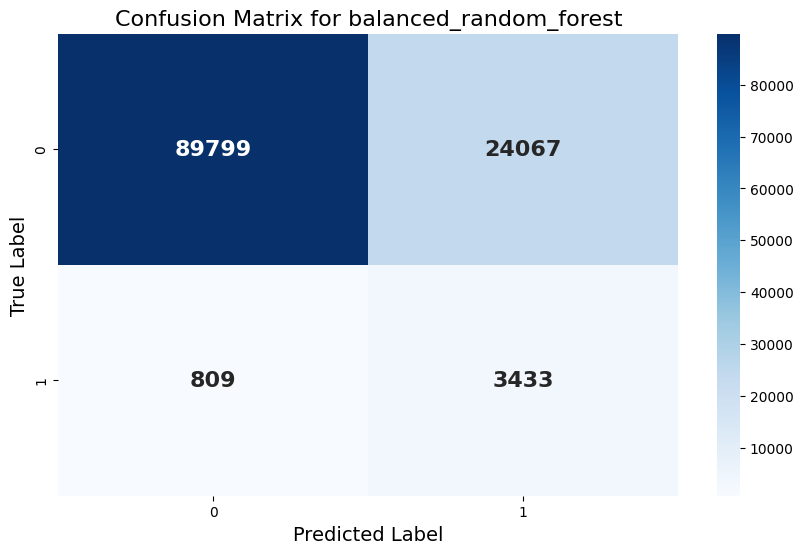

In [21]:
for model_name, pipeline in trained_models.items():
    y_pred = pipeline.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', annot_kws={"size": 16, "weight": "bold"})
    plt.title(f"Confusion Matrix for {model_name}", fontsize=16 )
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.show()

## Precisión y Recall

### Precision
Indica cuántas de las transacciones clasificadas como fraude realmente lo son. random_forest tiene la mayor precisión (0.902703), seguido por xgboost (0.840153).

### Recall
Indica cuántas de las transacciones fraudulentas fueron correctamente identificadas. Aquí, balanced_random_forest destaca con un recall muy alto (0.809228), aunque su precisión es baja (0.124836), lo que sugiere un alto número de falsos positivos.

### F1 Score
Es una combinación de precisión y recall. Los modelos con mejor F1 Score son random_forest (0.268165), xgboost (0.261545), y knn (0.274858). Sin embargo, balanced_random_forest tiene un F1 Score más bajo (0.216306) debido a su baja precisión.

## Elapsed Time
El tiempo de entrenamiento varía significativamente. Modelos como naive_bayes y decision_tree son rápidos de entrenar, mientras que knn es mucho más lento. random_forest y balanced_random_forest también son bastante eficientes en términos de tiempo considerando su buen rendimiento.

## Selección del Mejor Modelo
- random_forest parece ser la mejor opción general, con alto ROC AUC (0.882752), alta precisión (0.902703), y un F1 Score relativamente alto (0.268165).
- xgboost también es una buena opción, con un ROC AUC de 0.879682 y un buen balance entre precisión y recall.
- balanced_random_forest podría ser útil si el objetivo principal es capturar la mayoría de los fraudes (alto recall), aunque a costa de una precisión más baja.


In [ ]:
plt.figure(figsize=(10, 6))
for model_name, pipeline in trained_models.items():
    fpr, tpr, _ = roc_curve(y_test, pipeline.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

![texto_alternativo](roc.jpeg)


Los modelos Bosque Aleatorio, XGBoost y Bosque Aleatorio Balanceado tienen las puntuaciones AUC más altas (0.88), indicando que tienen el mejor rendimiento entre los modelos listados.

Naive Bayes tiene la puntuación AUC más baja (0.73), sugiriendo que tiene el rendimiento más débil entre los modelos.

La Regresión Logística y k-Vecinos Más Cercanos tienen puntuaciones AUC moderadas (0.74 y 0.77 respectivamente).


# Random Forest y XGBoost

Ambos modelos son fuertes y se complementan bien. Random Forest es bueno para capturar interacciones no lineales, mientras que XGBoost es excelente para captar relaciones más complejas debido a su enfoque de boosting.

# Balanced Random Forest

Aporta valor al capturar una mayor cantidad de fraudes, lo que puede ser beneficioso para mejorar el recall del modelo final.

# Evaluación y Ajuste

Después de entrenar el modelo de stacking, es importante evaluar su rendimiento utilizando métricas como precisión, recall, F1 score y AUC ROC. Además, podrías considerar ajustar los hiperparámetros de los modelos base y del modelo meta para optimizar aún más el rendimiento.

# Conclusión

El stacking es una técnica poderosa que, cuando se implementa correctamente. En este caso, Random Forest, XGBoost y Balanced Random Forest son buenas opciones como modelos base, con la regresión logística como modelo meta, debido a su capacidad para aprender combinaciones lineales de las predicciones de los modelos base.
